# Homework Set 10

In [1]:
%pylab inline
import pandas as pd

import fmt

Populating the interactive namespace from numpy and matplotlib


## Problem 1

Use the dual objective discussed in class to solve the following maximum entropy optimization problems.

Find the the maximum entropy (ME) distribution without any prior distributions (equivalent to uniform priors) with the following constraints:

1. with constraints of $\mathbb{E}[x] = 0$ and $\mathbb{E}[x^2] = 1$; show that the resulting distribution is indeed normal.
2. does your ME distribution from #1 depend on the range of the discrete samples? for example, do the resulting ME distribution look normal if the discrete samples span only [-1.5, 1.5]? explain why.
3. define a transformation of $y = e^x$, where $y$ is a lognormal distribution if $x$ is normal. Solve the ME problem using equal spaced samples in $y$ with the constraint $\mathbb{E}[\log(y)]=0$ and $\mathbb{E}[\log^2(y)] = 1$, and check if the resulting $y$ distribution is lognormal (it is not). 
4. Explain why your step 3 do not result in a lognormal distribution.
5. [optional] Can you adjust the prior distribution in #3 to reproduce the similar results as in #1 without changing the equal-spaced sampling in $y$?

Hint: 
* this problem illustrate that the importance of the prior distributions.
* You can use the me package as part of the class library to solve this problem. You will get extra credit if you can implement your own version of the ME optimizations. If you choose to implement your own, beware that the exp() function may overflow, so you need to apply a cap before calling exp().
* for #1. you should try a discretization of a wide range first, for example (-6, 6) with small sampling steps
* the Q-Q plot is an effective way to show whether two distributions are similar. Google search Q-Q plot if you don't know what it is.

## Solution

A gradient based optimizer is effective for solving the dual problem because the gradient of the dual objective function is available in close form.

1: the best way to compare two distribution is to show the Q-Q plot, as given below. A staight line in QA plot between the ME distribution and the normal distribution shows that the ME distribution is indeed normal.

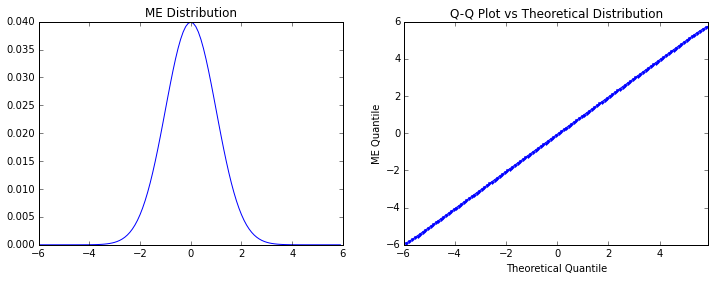

In [6]:
import me
from scipy.optimize import minimize
from scipy.stats import norm

def showME(x, a, u, e, q, icdf) :
    dual = me.MaxEntDual(q, a, u, e)

    res = minimize(dual.dual, np.zeros(len(u)), jac=dual.grad, method="BFGS")
    assert res.success, "optimization failed for ME" # ensure that the optimization is successful
    p = dual.dist(res.x)

    figure(figsize=[12, 4])
    subplot(1, 2, 1)
    plot(x, p);
    title('ME Distribution');

    subplot(1, 2, 2)
    qme = np.cumsum(p)
    xn = icdf(qme)
    plot(xn, x, '.-')
    xlim(x[0], x[-1]);
    xlabel('Theoretical Quantile')
    ylabel('ME Quantile')
    title('Q-Q Plot vs Theoretical Distribution');
    
    return p
    
x = np.arange(-6, 6, .1)
a = np.array([x*x, x])
u = np.array([1., 0])
e = np.array([0, 0])
q = np.ones(np.size(x))

showME(x, a, u, e, q, norm.ppf);

2: the distribution is no longer normal, this is because the prior distribution is different, limiting the range of samples is equivalent to having a prior distribution with a narrower support.

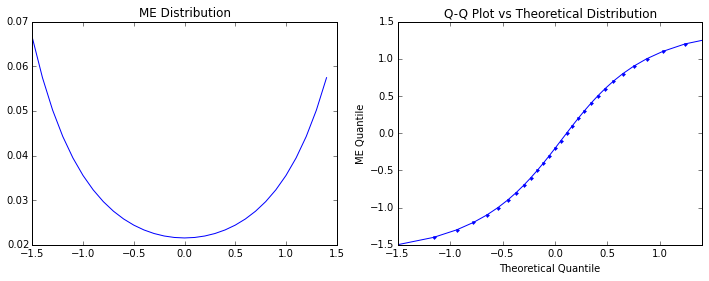

In [7]:
x = np.arange(-1.5, 1.5, .1)
a = np.array([x*x])
u = np.array([1.])
e = np.array([0])
q = np.ones(np.size(x))

showME(x, a, u, e, q, norm.ppf);

3: the resulting distribution is not lognormal, as shown by the Q-Q plot. 

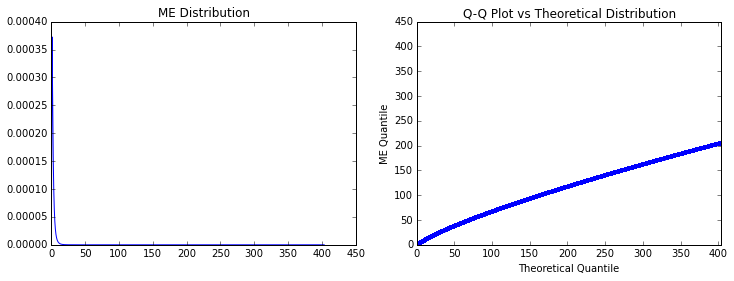

In [8]:
x = np.arange(np.exp(-6), np.exp(6), .001)

a = np.array([np.log(x)**2])
u = np.array([1.])
e = np.array([0])
q = np.ones(np.size(x))

logn_icdf = lambda x : np.exp(norm.ppf(x))

showME(x, a, u, e, q, logn_icdf);

4/5: the main reason for the difference is that the prior for #3 is a uniform distribution in $\log(x)$, which is different from a uniform distribution in $x$, which is the prior in #1. We need to set the prior distribution density to $\frac{1}{y}$ to mimic an uniform prior  in $x$ because:

$$ \int c \; dx = \int c \frac{dx}{dy} dy =  \int c \frac{d\log(y)}{dy} dy = \int c \frac{1}{y} dy $$

the resulting ME distribution is largely lognormal after this adjustment. There are a small deviation for very large values in $y$ due to the discrete sample range.

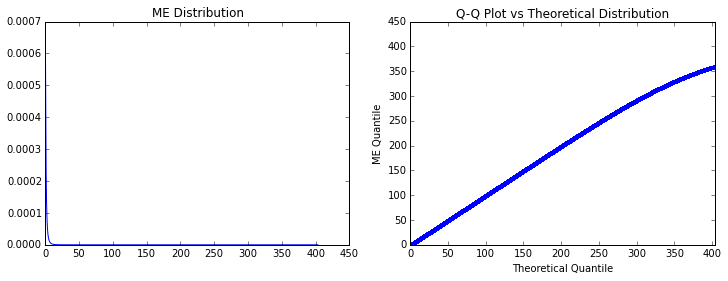

In [9]:
q = 1./x
showME(x, a, u, e, q, logn_icdf);

## Problem 2

Often times, we run into conflicting constraints in practice, 

1. try to solve the ME optimization with standard normal as the prior distribution, with the following conflicting skewness constraints of $E[x^3] = -2$ and $E[x^3] = 2$.  Show that the numerical optimizer will fail to find a solution if we don't allow error bounds (ie, like the bid/ask discussed in class); check your implementation so that it fails gracefully (i.e., it should not stop from running the rest of your ipython notebook cells when "Run All").
2. show that you can find a solution by introducing error bounds, and shift the distribution to skew left or right by adjusting the error bounds related to these donstraints.

This exercise illustrates that error bounds improve the robustness of the ME method.

### Solution

1: the optimizer failed to find any solution with conflicting constraints.

In [10]:
x = np.arange(-6, 6, .1)
a = np.array([x**3, x**3])
u = np.array([2., -2])
e = np.array([0, 0])
q = norm.pdf(x)

try : 
    p = showME(x, a, u, e, q, norm.ppf)
except AssertionError as e:
    print e

optimization failed for ME


2: A solution is found if we allow any positive error bounds, however small it may be (though must be greater than $O(\sqrt{\epsilon_m})$), where $\epsilon_m$ is the machine precision.

error bounds [1e-06, 1e-06] , resulting skewness: 7.41084e-06
error bounds [0, 1e-06] , resulting skewness: 2
error bounds [1e-06, 0] , resulting skewness: -2


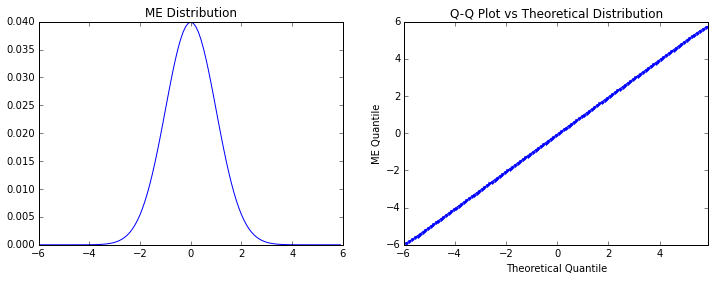

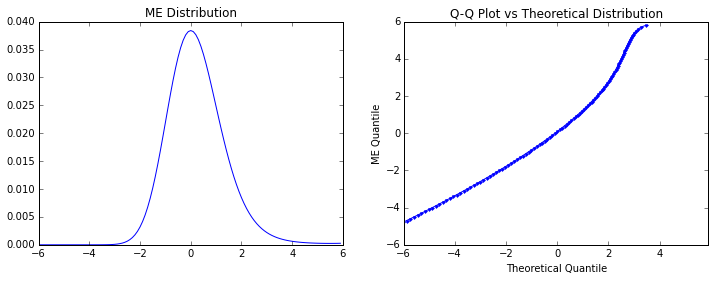

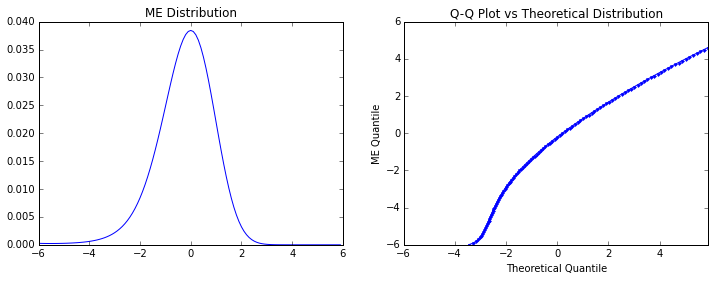

In [11]:
def meSkew(e) :
    p = showME(x, a, u, np.array(e), q, norm.ppf)
    print "error bounds [%g, %g]" % e,  ", resulting skewness: %g" % a.dot(p)[0]

meSkew((1e-6, 1e-6))
meSkew((0, 1e-6))
meSkew((1e-6, 0))

## Problem 3

[open question] The asset allocation problem could be formulated as a maximum entropy optimization problem, if we view the dollar value of asset allocation as a distribution. Please give your thoughts on whether maximum entropy is a sensible objective function for solving the asset allocation problem. 

Hint: compare maximum entropy with the standard mean/variance method of asset allocation. Please give very short and concise answers. (this question can be anwsered in no more than 2 sentences).

### Solution

This is not a good idea because the asset distribution is not really a distribution of any random variable, making it ill-suited for maximum entropy method. Recall that information entropy is only meaningful with a random variable. This question is really to show that even though we could formulate the problem as a ME problem, it does not necessarily make sense.

## Problem 4

A classic problem of Shapley allocation is the glove game, where three players A, B, C each has a single glove of left, left and right hand. Assuming that one pair of gloves with left and right hand worth $1, and unpaired gloves are worthless. 

1. apply Shapley allocation to divide the \$1 total value among the three players, by listing all possible permutations and take the average.
2. can you compute the stand-alone or Euler allocation for this game?
3. suppose B and C belongs to the same team, and A belongs to a different team, compute the allocation between two teams of [A] and [BC] using both Shapley and Constrained Shapley; comment on which allocation gives more sensible results. 
4. Repeat 3, but this time A and B (the two left hands) formed a team, while C is on his own. How does the results change?
5. derive the general case with 1 right glove and $n$ left goves, derive the allocation to the right hand glove under following two cases:
  1. no teams, under Shapley allocation
  2. all the $n$ left hands formed a term, under C-Shapley allocation
6. [open question] comment on whether fairness depends on organization

Hints:
* For #1: since the number of players are small, you can enumerate all possible permutations.
* For #5A: you only need to consider all the positions the right hand glove can appear amongst the $n$ left gloves, and the incremental contribution of the right hand glove at each position.

### Solution

1. the allocation is 1/6, 1/6, 2/3 after enumerate all 6 permuations.
2. no, because any of the player has a value of 0 on their own
3. the allcation is 0 and 1 for [A] and [BC] under C-Shapley allocation, and it is more sensible.
4. this time, the [AB] and [C] each has allocation of 0.5 under C-Shapley.
5. 
  1. the allocation to the right hand glove is $\frac{n}{n+1}$. We can simply consider all the possible $(n+1)$ positions of the right glove, each with a probability of $\frac{1}{n+1}$. Out of the $(n+1)$ positions, only one of the position (when right glove is at the front of the permutation) has a \$0 pay off, the rest positions all have \$1 payoff to the right glove. 
  2. under C-Shapley, the left hands and the single right hand each get \$0.50
6. Yes, fairness is a function of organization. By forming a team,  the left hand gloves get more bargain power in the allocaiton.